param_num: 450340
[0, 0.5935821533203125, 1.187164306640625, 1.7807464599609375, 2.37432861328125, 2.9679107666015625, 3.561492919921875, 4.1550750732421875, 4.7486572265625, 5.3422393798828125, 5.935821533203125, 6.5294036865234375, 7.12298583984375, 7.7165679931640625, 8.310150146484375, 8.903732299804688, 9.497314453125, 10.090896606445312, 10.684478759765625, 11.278060913085938, 11.87164306640625, 12.465225219726562, 13.058807373046875, 13.652389526367188, 14.2459716796875, 14.839553833007812, 15.433135986328125, 16.026718139648438, 16.62030029296875, 17.213882446289062, 17.807464599609375, 18.401046752929688, 18.99462890625, 19.588211059570312, 20.181793212890625, 20.775375366210938, 21.36895751953125, 21.962539672851562, 22.556121826171875, 23.149703979492188, 23.7432861328125, 24.336868286132812, 24.930450439453125, 25.524032592773438, 26.11761474609375, 26.711196899414062, 27.304779052734375, 27.898361206054688, 28.491943359375, 29.085525512695312, 29.679107666015625, 30.272689

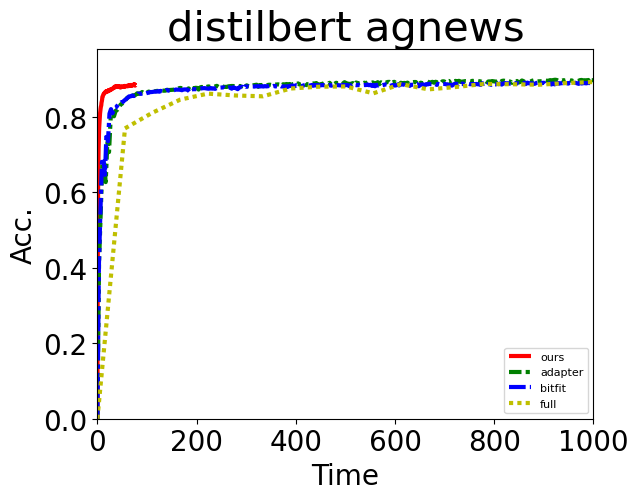

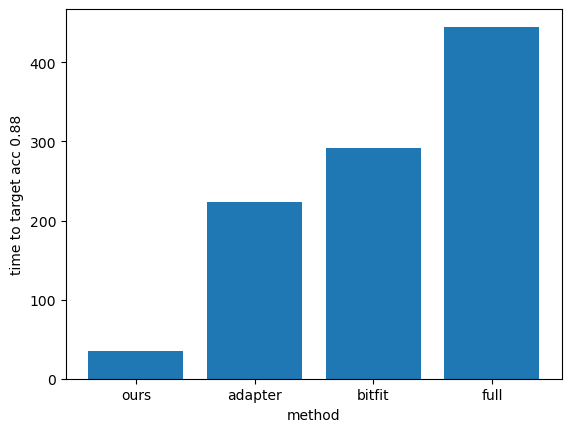

In [3]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "agnews"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_1000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":1,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.88
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()

param_num: 450340
[0, 2.3435821533203125, 4.687164306640625, 7.0307464599609375, 9.37432861328125, 11.717910766601562, 14.061492919921875, 16.405075073242188, 18.7486572265625, 21.092239379882812, 23.435821533203125, 25.779403686523438, 28.12298583984375, 30.466567993164062, 32.810150146484375, 35.15373229980469, 37.497314453125, 39.84089660644531, 42.184478759765625, 44.52806091308594, 46.87164306640625, 49.21522521972656, 51.558807373046875, 53.90238952636719, 56.2459716796875, 58.58955383300781, 60.933135986328125, 63.27671813964844, 65.62030029296875, 67.96388244628906, 70.30746459960938, 72.65104675292969, 74.99462890625, 77.33821105957031, 79.68179321289062, 82.02537536621094, 84.36895751953125, 86.71253967285156, 89.05612182617188, 91.39970397949219, 93.7432861328125, 96.08686828613281, 98.43045043945312, 100.77403259277344, 103.11761474609375, 105.46119689941406, 107.80477905273438, 110.14836120605469, 112.491943359375, 114.83552551269531, 117.17910766601562, 119.52268981933594

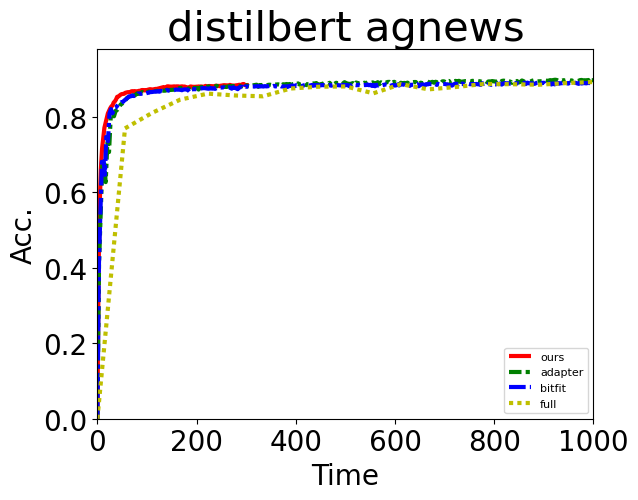

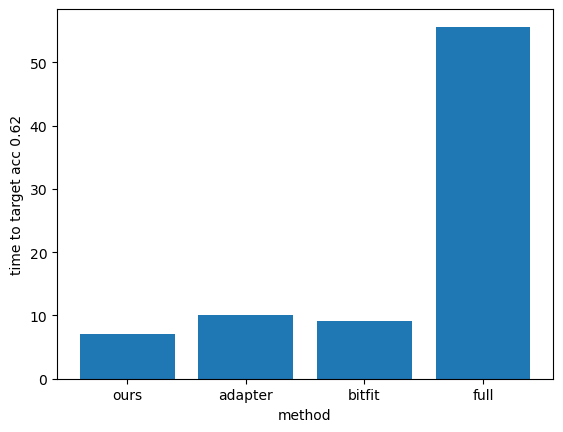

In [4]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "agnews"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_1000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":8,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.62
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()